# **Test de grabaci√≥n y transcripci√≥n de audio**

Este notebook usa las funciones de `utils_audio.py` para:
1. Grabar audio desde el micr√≥fono (usando `sounddevice`).
2. Preprocesar el audio.
3. Transcribir con Whisper.

Si la grabaci√≥n no es posible en el entorno, cargar√° archivos `.wav` de la carpeta `audio/`.

---
### **Librer√≠as**

In [59]:
# Importar utilidades de audio
from utils_audio import load_whisper_model, preprocess_audio_file, transcribe_audio_file
import sounddevice as sd
import numpy as np
import tempfile, os
from scipy.io.wavfile import write
from IPython.display import Audio
import soundfile as sf
import torch
import librosa

# Ignorar los warnings 
import warnings
warnings.filterwarnings("ignore")

---
### **1. Grabar audio desde el micr√≥fono**

In [60]:
def grabar_audio(clase: str, base_dir: str = 'data/outputs/6_audios', fs: int = 16000, duration: int = 5):
    """
    Graba audio desde el micr√≥fono y lo guarda en una carpeta espec√≠fica con nombres iterativos.

    Args:
        clase (str): Subcarpeta dentro de `base_dir` donde se guardar√° el audio.
        base_dir (str): Carpeta base donde se almacenar√°n los audios. Por defecto es 'data/outputs/6_audios'.
        fs (int): Frecuencia de muestreo. Por defecto es 16000 Hz.
        duration (int): Duraci√≥n de la grabaci√≥n en segundos. Por defecto es 5 segundos.
    """
    # Crear la carpeta si no existe
    output_dir = os.path.join(base_dir, clase)
    os.makedirs(output_dir, exist_ok=True)

    # Determinar el nombre del archivo iterativo
    existing_files = [f for f in os.listdir(output_dir) if f.lower().endswith('.wav')]
    next_index = len(existing_files) + 1
    audio_filename = f'audio_{next_index}.wav'
    audio_path = os.path.join(output_dir, audio_filename)

    print(f'Grabando {duration}s de audio a {fs}Hz en {audio_path}...')

    # Grabar audio
    try:
        recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
        sd.wait()  # Esperar a que termine
        print('Grabaci√≥n completada')
        
        # Guardar a WAV en la carpeta especificada
        write(audio_path, fs, np.squeeze(recording))
        display(Audio(audio_path, rate=fs))
        return audio_path
    except Exception as e:
        print('No fue posible grabar:', e)
        
        # Fallback: tomar primer archivo de carpeta 'audio'
        files = [f for f in os.listdir('audio') if f.lower().endswith('.wav')]
        if files:
            fallback_path = os.path.join('audio', files[0])
            print('Usando archivo de prueba:', fallback_path)
            display(Audio(fallback_path))
            return fallback_path
        else:
            raise RuntimeError('No hay forma de obtener audio')

In [62]:
# grabamos un audio de prueba
# administracion, efectos_secundarios, otros
grabar_audio('', base_dir='audio', fs=16000, duration=5)

Grabando 5s de audio a 16000Hz en audio\audio_1.wav...
Grabaci√≥n completada


'audio\\audio_1.wav'

---
### **2. Preprocesar y transcribir**

In [3]:
# Modelos disponibles en Whisper 
available_models = ["tiny", "base", "small", "medium", "large"]

# Pedir al ususario el modelo a usar
#model_size = input(f"¬øQu√© modelo usar? ({', '.join(available_models)}): ").strip().lower()
model_size = "medium" # mejor este de momento

In [4]:
# Cargar modelo Whisper (si no est√° ya cargado)
model, device = load_whisper_model(model_size)

# Preprocesar archivo
proc_path = preprocess_audio_file(audio_path, target_sr=16000)
print('Archivo preprocesado en:', proc_path)

# Funci√≥n para transcribir un array NumPy con Whisper
def transcribe_numpy(audio_array: np.ndarray, sr: int):
    # Asegurar que el dtype es float32
    audio_array = audio_array.astype(np.float32)
    # Convertir a tensor y mover al dispositivo
    audio_tensor = torch.from_numpy(audio_array).to(device)
    # Ejecutar la transcripci√≥n
    result = model.transcribe(audio_tensor)
    return result.get('text', '').strip()

# Leer datos PCM directamente
audio_array, sr = sf.read(proc_path)
print(f"Le√≠dos {audio_array.shape[0]} muestras a {sr} Hz")

# Re-muestreo si hace falta
if sr != 16000:
    import librosa
    audio_array = librosa.resample(audio_array, orig_sr=sr, target_sr=16000)
    print(f"Re-muestreado a {audio_array.shape[0]} muestras a 16000 Hz")

# Ejecutar transcripci√≥n
text = transcribe_numpy(audio_array, sr)
print('Transcripci√≥n:')
print(text)


Archivo preprocesado en: /var/folders/z2/b_41nsk11996m00f1c0095th0000gn/T/test_record_16k_mono.wav
Le√≠dos 80000 muestras a 16000 Hz
Transcripci√≥n:
Hola, ¬øqu√© tal est√°s? Hola, hola, hola, hola, esto es una prueba, hola.


---
### **3. Cargar archivos de audio**

In [4]:
import os
import pandas as pd

data = []
base_dir = "data\\outputs\\6_audios"
for label in os.listdir(base_dir):
    folder = os.path.join(base_dir, label)
    if not os.path.isdir(folder): continue
    for fn in os.listdir(folder):
        if fn.lower().endswith((".wav",".mp3")):
            path = os.path.join(folder, fn)
            data.append({"path": path, "label": label})

df = pd.DataFrame(data)
display(df.head())

path           label
0   data\outputs\6_audios\administracion\audio_1.wav  administracion
1  data\outputs\6_audios\administracion\audio_10.wav  administracion
2   data\outputs\6_audios\administracion\audio_2.wav  administracion
3   data\outputs\6_audios\administracion\audio_3.wav  administracion
4   data\outputs\6_audios\administracion\audio_4.wav  administracion

#### **Informacion de los audios**

Total de archivos: 30

Archivos por clase:
 label
administracion         10
efectos_secundarios    10
otros                  10
Name: count, dtype: int64


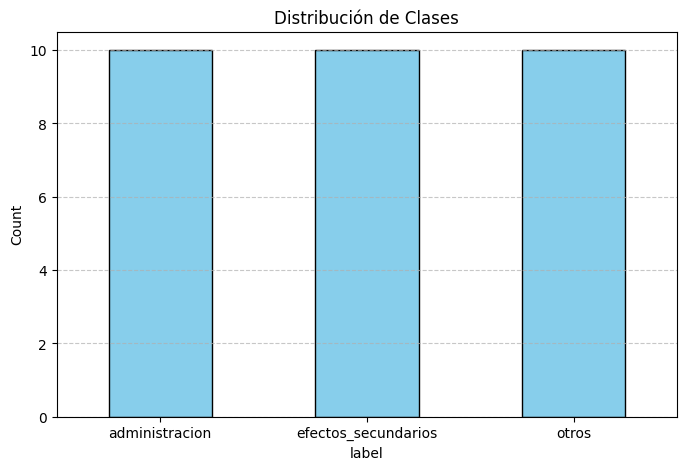


Descripci√≥n de duraciones (s):
 count    30.0
mean      5.0
std       0.0
min       5.0
25%       5.0
50%       5.0
75%       5.0
max       5.0
Name: duration_s, dtype: float64


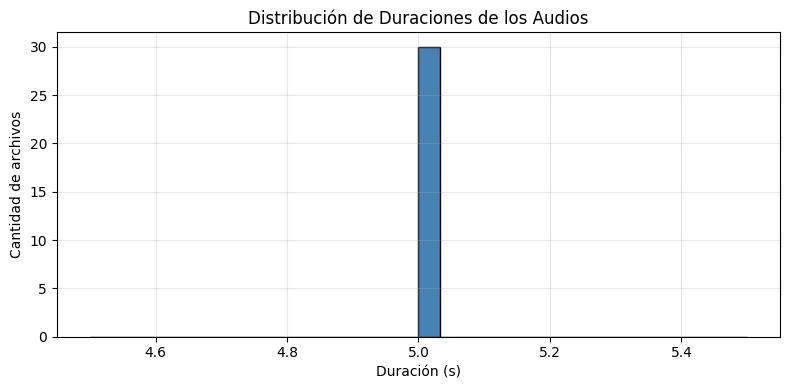


Frecuencia de sample rates originales:
 sr_original
16000    30
Name: count, dtype: int64

Frecuencia de canales:
 channels
1    30
Name: count, dtype: int64


In [47]:
import pandas as pd
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

# Asumimos que 'df' ya est√° definido con columnas 'path' y 'label'

# 1) Recopilar metadata de cada audio
durations = []
samplerates = []
channels = []

for path in df["path"]:
    info = sf.info(path)
    durations.append(info.frames / info.samplerate)
    samplerates.append(info.samplerate)
    channels.append(info.channels)

# A√±adimos columnas al DataFrame
df["duration_s"] = durations
df["sr_original"] = samplerates
df["channels"] = channels

# 2) Resumen de la colecci√≥n
print("Total de archivos:", len(df))

# Contar las ocurrencias de cada clase
class_distribution = df['label'].value_counts()
print("\nArchivos por clase:\n", df["label"].value_counts())

# Crear la gr√°fica de barras
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribuci√≥n de Clases')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3) Estad√≠sticas de duraci√≥n
print("\nDescripci√≥n de duraciones (s):\n", df["duration_s"].describe())

# 4) Histograma de duraciones
plt.figure(figsize=(8,4))
plt.hist(df["duration_s"], bins=30, color="steelblue", edgecolor="black")
plt.title("Distribuci√≥n de Duraciones de los Audios")
plt.xlabel("Duraci√≥n (s)")
plt.ylabel("Cantidad de archivos")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5) Revisar sample rates y canales
print("\nFrecuencia de sample rates originales:\n", df["sr_original"].value_counts())
print("\nFrecuencia de canales:\n", df["channels"].value_counts())


Reproduciendo audio 1: audio_construccion.wav


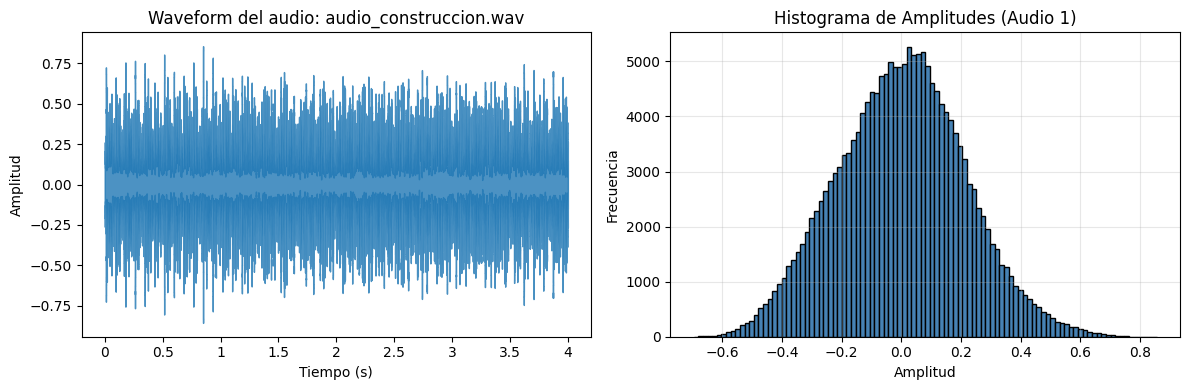

Reproduciendo audio 2: audio_1.wav


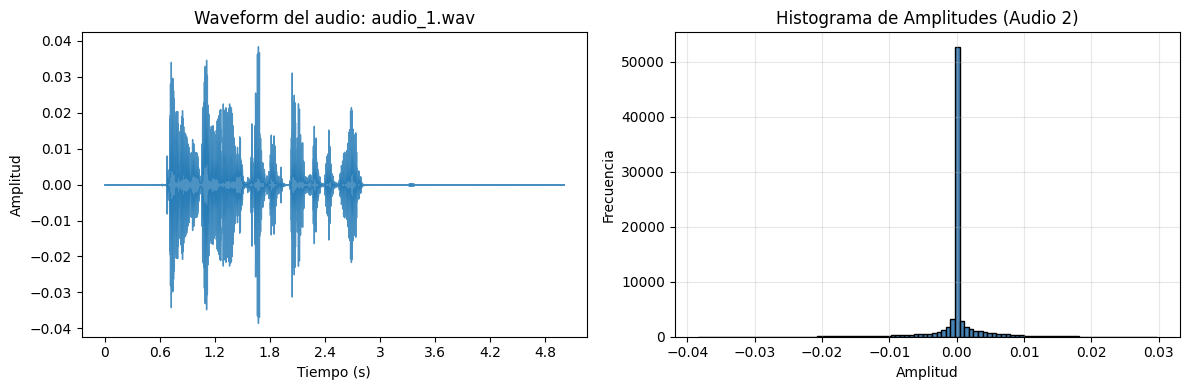

In [52]:
# Ejemplo con el primer audio del DataFrame
path_example_1 = 'audio_construccion.wav'
path_example_2 = df['path'].iloc[0]  # Primer audio del DataFrame

# Cargar ambos audios
y1, sr1 = librosa.load(path_example_1, sr=None, mono=True)
y2, sr2 = librosa.load(path_example_2, sr=None, mono=True)

# Reproducir audio 1
print(f"Reproduciendo audio 1: {os.path.basename(path_example_1)}")
ipd.display(ipd.Audio(y1, rate=sr1))

# Crear figura con 2 subplots para audio 1
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gr√°fico 1: Waveform del audio 1
axes[0].set_title(f"Waveform del audio: {os.path.basename(path_example_1)}")
librosa.display.waveshow(y1, sr=sr1, alpha=0.8, ax=axes[0])
axes[0].set_xlabel("Tiempo (s)")
axes[0].set_ylabel("Amplitud")

# Gr√°fico 2: Histograma del audio 1
axes[1].set_title("Histograma de Amplitudes (Audio 1)")
axes[1].hist(y1, bins=100, color='steelblue', edgecolor='black')
axes[1].set_xlabel("Amplitud")
axes[1].set_ylabel("Frecuencia")
axes[1].grid(alpha=0.3)

# Ajustar dise√±o
plt.tight_layout()
plt.show()

# Reproducir audio 2
print(f"Reproduciendo audio 2: {os.path.basename(path_example_2)}")
ipd.display(ipd.Audio(y2, rate=sr2))

# Crear figura con 2 subplots para audio 2
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gr√°fico 3: Waveform del audio 2
axes[0].set_title(f"Waveform del audio: {os.path.basename(path_example_2)}")
librosa.display.waveshow(y2, sr=sr2, alpha=0.8, ax=axes[0])
axes[0].set_xlabel("Tiempo (s)")
axes[0].set_ylabel("Amplitud")

# Gr√°fico 4: Histograma del audio 2
axes[1].set_title("Histograma de Amplitudes (Audio 2)")
axes[1].hist(y2, bins=100, color='steelblue', edgecolor='black')
axes[1].set_xlabel("Amplitud")
axes[1].set_ylabel("Frecuencia")
axes[1].grid(alpha=0.3)

# Ajustar dise√±o
plt.tight_layout()
plt.show()


FALTA HACER AUDIOS CON RUIDO Y SIN RUIDO DICIENDO LO MISMO PARA VER SI PODEMOS ELIMINAR AL M√ÅXIMO EL RUIDO

#### **PREPROCESADO COMPLETO: Limpieza de ruido, silencio, pre-√©nfasis**

In [53]:
import numpy as np
import librosa
import librosa.display
from scipy.signal import butter, filtfilt
try:
    import noisereduce as nr
    _HAS_NOISEREDUCE = True
except ImportError:
    _HAS_NOISEREDUCE = False


def butter_bandpass(lowcut: float, highcut: float, fs: int, order: int = 4):
    """
    Dise√±a un filtro Butterworth pasa-banda.

    Par√°metros:
    - lowcut: frecuencia de corte baja en Hz.
    - highcut: frecuencia de corte alta en Hz.
    - fs: frecuencia de muestreo en Hz.
    - order: orden del filtro (defecto=4).

    Retorna:
    - b, a: coeficientes del filtro.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def bandpass_filter(y: np.ndarray, sr: int,
                    lowcut: float = 300.0,
                    highcut: float = 3400.0,
                    order: int = 4) -> np.ndarray:
    """
    Aplica un filtro pasa-banda para conservar s√≥lo la banda de voz.

    Par√°metros:
    - y: se√±al de audio (1D numpy array).
    - sr: frecuencia de muestreo en Hz.
    - lowcut, highcut: l√≠mites de frecuencia en Hz.
    - order: orden del filtro.

    Retorna:
    - Se√±al filtrada.
    """
    b, a = butter_bandpass(lowcut, highcut, sr, order)
    return filtfilt(b, a, y)


def pre_emphasis(y: np.ndarray, coef: float = 0.97) -> np.ndarray:
    """
    Aplica filtro de pre-√©nfasis para realzar frecuencias altas.

    F√≥rmula:
        y[n] = x[n] - coef * x[n-1]

    Par√°metros:
    - y: se√±al mono (1D numpy array).
    - coef: coeficiente de pre-√©nfasis (defecto=0.97).

    Retorna:
    - Se√±al con pre-√©nfasis aplicada.
    """
    return np.append(y[0], y[1:] - coef * y[:-1])


def normalize_peak(y: np.ndarray) -> np.ndarray:
    """
    Normalizaci√≥n por pico: escala la se√±al para que su amplitud m√°xima sea 1.

    Par√°metros:
    - y: se√±al de audio.

    Retorna:
    - Se√±al normalizada.
    """
    peak = np.max(np.abs(y))
    return y / peak if peak > 0 else y


def normalize_rms(y: np.ndarray, target_rms: float = 0.1) -> np.ndarray:
    """
    Normalizaci√≥n RMS: ajusta la se√±al para que su RMS coincida con target_rms.

    Par√°metros:
    - y: se√±al de audio.
    - target_rms: RMS objetivo (defecto=0.1).

    Retorna:
    - Se√±al normalizada.
    """
    rms = np.sqrt(np.mean(y**2))
    return y * (target_rms / rms) if rms > 0 else y


def frame_signal(y: np.ndarray, sr: int,
                 frame_length: int = None,
                 hop_length: int = None) -> np.ndarray:
    """
    Divide la se√±al en frames de tama√±o fijo.

    Par√°metros:
    - y: se√±al de audio.
    - sr: frecuencia de muestreo.
    - frame_length: tama√±o del frame en muestras (defecto 25 ms).
    - hop_length: salto entre frames en muestras (defecto 10 ms).

    Retorna:
    - Matriz de shape (n_frames, frame_length).
    """
    if frame_length is None:
        frame_length = int(0.025 * sr)
    if hop_length is None:
        hop_length = int(0.010 * sr)
    num_frames = 1 + (len(y) - frame_length) // hop_length
    frames = np.lib.stride_tricks.as_strided(
        y,
        shape=(num_frames, frame_length),
        strides=(y.strides[0] * hop_length, y.strides[0])
    )
    return frames


def apply_window(frames: np.ndarray, window_fn=np.hamming) -> np.ndarray:
    """
    Aplica ventana de suavizado a cada frame para reducir leakage.

    Par√°metros:
    - frames: matriz (n_frames, frame_length).
    - window_fn: funci√≥n de ventana (defecto np.hamming).

    Retorna:
    - Frames aplicando la ventana.
    """
    win = window_fn(frames.shape[1])
    return frames * win[None, :]


def reduce_noise(y: np.ndarray, sr: int, prop_decrease: float = 1.0) -> np.ndarray:
    """
    Realiza reducci√≥n de ruido por spectral gating usando noisereduce.

    Par√°metros:
    - y: se√±al de audio.
    - sr: frecuencia de muestreo.
    - prop_decrease: proporci√≥n de reducci√≥n (0 a 1).

    Retorna:
    - Se√±al con ruido reducido.

    Nota: requiere instalar noisereduce (pip install noisereduce).
    """
    if not _HAS_NOISEREDUCE:
        raise ImportError("Para usar reduce_noise instala la librer√≠a noisereduce.")
    return nr.reduce_noise(y=y, sr=sr, prop_decrease=prop_decrease)


def preprocess_audio(path: str,
                     sr: int = 16000,
                     trim_db: float = 20.0,
                     lowcut: float = 300.0,
                     highcut: float = 3400.0,
                     pre_coef: float = 0.97,
                     rms_target: float = 0.1,
                     reduce_noise_flag: bool = False) -> np.ndarray:
    """
    Pipeline completo de preprocesado de audio:
    1) Carga y conversi√≥n a mono.
    2) (Opcional) Reducci√≥n de ruido.
    3) Recorte de silencio inicial y final.
    4) Pre-√©nfasis.
    5) Filtro pasa-banda para voz.
    6) Normalizaci√≥n por RMS.

    Par√°metros:
    - path: ruta al archivo de audio.
    - sr: frecuencia de muestreo deseada.
    - trim_db: umbral dB para recorte de silencio.
    - lowcut, highcut: l√≠mites de frecuencia para filtrado.
    - pre_coef: coeficiente de pre-√©nfasis.
    - rms_target: RMS objetivo para normalizaci√≥n.
    - reduce_noise_flag: activar reducci√≥n de ruido.

    Retorna:
    - Se√±al procesada lista para extracci√≥n de features.
    """
    # 1) Carga
    y, _ = librosa.load(path, sr=sr, mono=True)

    # 2) Reducci√≥n de ruido si se solicita
    if reduce_noise_flag:
        y = reduce_noise(y, sr)

    # 3) Recorte de silencio
    y, _ = librosa.effects.trim(y, top_db=trim_db)

    # 4) Pre-√©nfasis
    y = pre_emphasis(y, coef=pre_coef)

    # 5) Filtrado pasa-banda
    y = bandpass_filter(y, sr, lowcut, highcut)

    # 6) Normalizaci√≥n RMS
    y = normalize_rms(y, target_rms=rms_target)

    return y

In [63]:
# Ejemplo de uso de preprocesado de audio
y_preprocesado = preprocess_audio('audio\\audio_1.wav')

# Reproducir audio preprocesado
import librosa.display
import IPython.display as ipd
ipd.Audio(y_preprocesado, rate=16000)


#### **Visualizaci√≥n del audio**

Playing audio for class: administracion


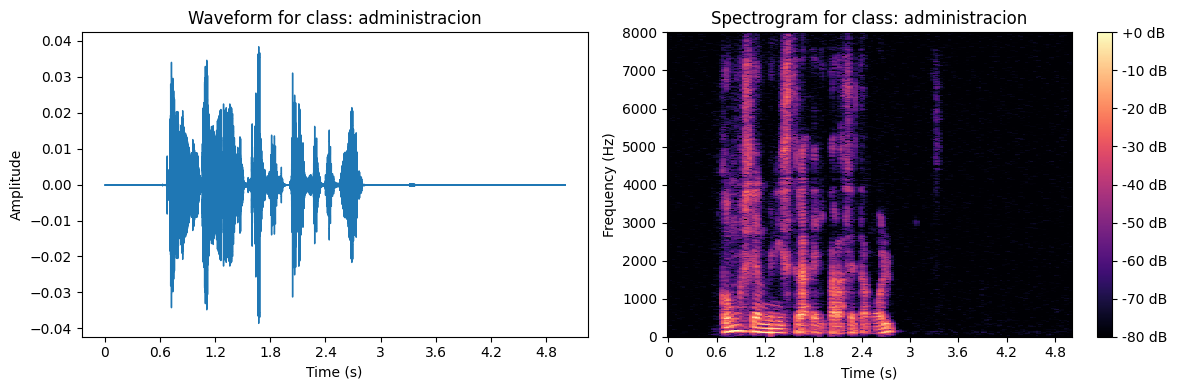

Playing audio for class: efectos_secundarios


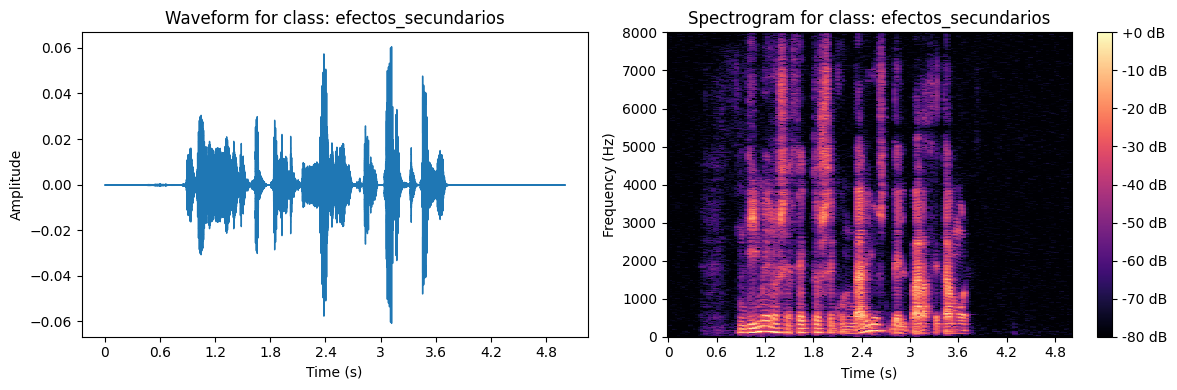

Playing audio for class: otros


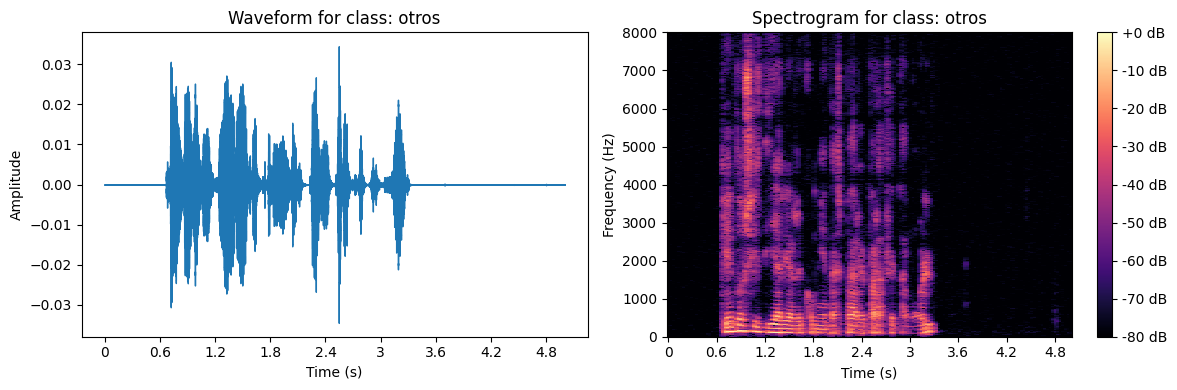

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

# Get one sample per class
sample_per_class = df.groupby("label").first().reset_index()

for _, row in sample_per_class.iterrows():
    filename = row["path"]
    label = row["label"]
    
    # Load audio file
    data, sample_rate = librosa.load(filename, sr=None)
    
    # Plot waveform and spectrogram side by side
    print(f"Playing audio for class: {label}")
    ipd.display(ipd.Audio(filename))
    
    plt.figure(figsize=(12, 4))
    
    # Plot waveform on the left
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(data, sr=sample_rate)
    plt.title(f"Waveform for class: {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    # Plot spectrogram on the right
    plt.subplot(1, 2, 2)
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(spectrogram, sr=sample_rate, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram for class: {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    
    plt.tight_layout()
    plt.show()

#### **Distribuci√≥n de clases**

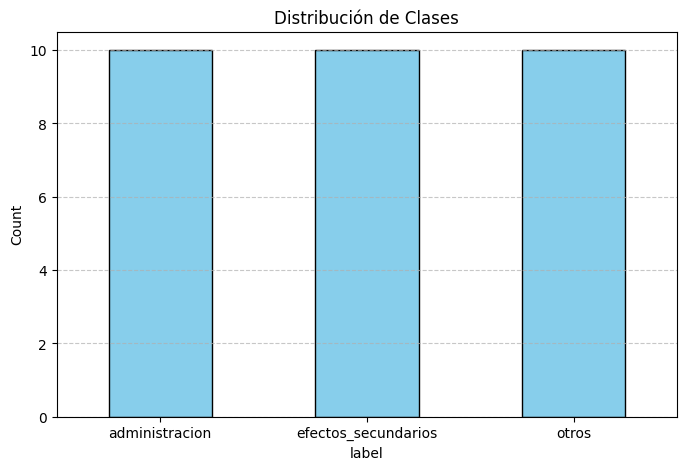

In [10]:
import matplotlib.pyplot as plt

# Contar las ocurrencias de cada clase
class_distribution = df['label'].value_counts()

# Crear la gr√°fica de barras
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribuci√≥n de Clases')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### **Quitar silencio de los audios** (ya lo hacemos en la limpieza de ruido)

In [ ]:
import librosa
import numpy as np

def remove_silence(y: np.ndarray,
                   top_db: float = 20.0):
    """
    Elimina los silencios al inicio y al final de una se√±al de audio.

    Par√°metros:
    - y: se√±al de audio (array 1D).
    - sr: sample rate de la se√±al (e.g. 16000).
    - top_db: umbral en dB para considerar silencio (por defecto 20 dB).

    Retorna:
    - y_trimmed: se√±al recortada sin silencios en extremos.
    """
    # librosa.effects.trim detecta y elimina silencios en la se√±al
    y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)
    return y_trimmed

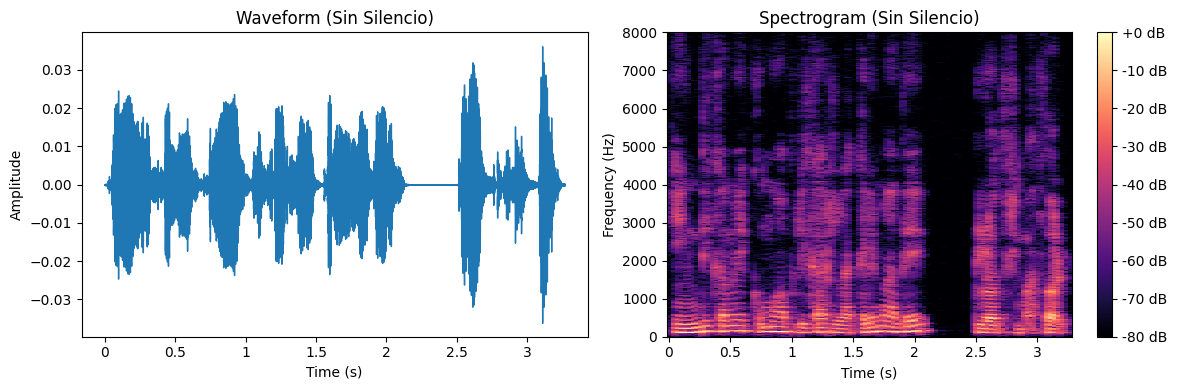

In [ ]:
# Cargamos audio
y, sr = librosa.load("data\outputs\\6_audios\\administracion\\audio_3.wav", sr=16000, mono=True)

# Elimina silencios inicial/final
y_silence = remove_silence(y, top_db=20.0)

# Escuchar audio sin silencio
ipd.display(ipd.Audio(y_silence, rate=sr))
plt.figure(figsize=(12, 4))

# Plot waveform
plt.subplot(1, 2, 1)
librosa.display.waveshow(y_silence, sr=sr)
plt.title("Waveform (Sin Silencio)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Plot spectrogram
plt.subplot(1, 2, 2)
spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(y_silence)), ref=np.max)
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Sin Silencio)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

#### **Zero Crossing**

In [23]:
def plot_zero_crossing(y: np.ndarray,
                       sr: int,
                       frame_length: int = 2048,
                       hop_length: int = 512):
    """
    Calcula la tasa de cruces por cero y muestra una gr√°fica de ZCR vs tiempo.

    Par√°metros:
    - y: se√±al de audio (1D numpy array).
    - sr: sample rate de la se√±al (e.g., 16000).
    - frame_length: tama√±o de la ventana en muestras (por defecto 2048).
    - hop_length: salto entre ventanas en muestras (por defecto 512).
    """
    # 1) Calcula ZCR por frame
    zcr = librosa.feature.zero_crossing_rate(
        y, frame_length=frame_length, hop_length=hop_length
    )[0]
    
    # 2) Convierte √≠ndices de frames a tiempo (segundos)
    times = librosa.frames_to_time(np.arange(len(zcr)), sr=sr, hop_length=hop_length)
    
    # 3) Graficar
    plt.figure(figsize=(10, 4))
    plt.plot(times, zcr, label="ZCR")
    plt.title("Zero Crossing Rate a lo largo del tiempo")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Tasa de Cruces por Cero")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return zcr

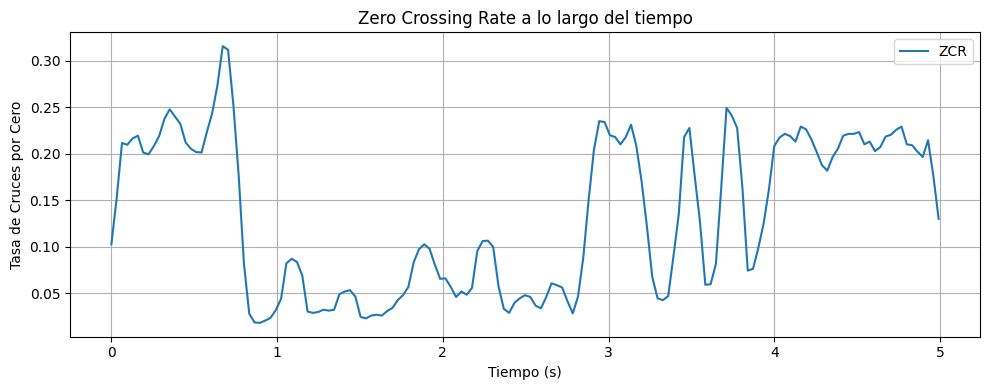

In [24]:
# Cargamos audio
y, sr = librosa.load("data\outputs\\6_audios\\administracion\\audio_3.wav", sr=16000, mono=True)

# Zero Crossing Rate
zcr = plot_zero_crossing(y, sr)

El Zero Crossing Rate (ZCR) mide la frecuencia con la que la se√±al de audio cambia de signo (de positivo a negativo o viceversa) por unidad de tiempo. En otras palabras, cuenta cu√°ntas veces cruza el valor cero en cada frame de la se√±al.

¬øQu√© significa y qu√© hace?

Matem√°ticamente, si 
ùë¶
[
ùëõ
]
y[n] es la amplitud de la se√±al en la muestra 
ùëõ
n, el ZCR por frame es

Z
C
R
=
1
2
ùëÅ
‚àë
ùëõ
=
1
ùëÅ
‚à£
sgn
‚Å°
(
ùë¶
[
ùëõ
]
)
‚àí
sgn
‚Å°
(
ùë¶
[
ùëõ
‚àí
1
]
)
‚à£
,
ZCR= 
2N
1
‚Äã
  
n=1
‚àë
N
‚Äã
  
‚Äã
 sgn(y[n])‚àísgn(y[n‚àí1]) 
‚Äã
 ,
donde 
sgn
‚Å°
(
‚ãÖ
)
sgn(‚ãÖ) es la funci√≥n signo y 
ùëÅ
N el n√∫mero de muestras del frame ‚Äã[AUDIO] Unstructured Da‚Ä¶.

¬øPara qu√© sirve?

Diferenciar tipos de sonido

Las se√±ales muy percutivas (golpes, tambores, sonidos met√°licos) tienen ZCR elevado, mientras que sonidos m√°s tonales (voces, cuerdas) lo tienen bajo ‚Äã[AUDIO] Unstructured Da‚Ä¶.

Detecci√≥n de voz vs. silencio o ruido

En Voice Activity Detection, ayuda a identificar segmentos de habla (ZCR moderado/bajo) frente a segmentos de ruido blanco (ZCR alto) o silencio (ZCR casi cero).

Segmentaci√≥n y onset detection

Detecci√≥n de inicios de notas o eventos sonoros: un pico en ZCR suele coincidir con un cambio brusco en la se√±al.

Caracterizaci√≥n de contenido

Como feature en tareas de clasificaci√≥n de audio (g√©nero musical, reconocimiento de emociones, clasificaci√≥n de efectos adversos en tu caso), aporta informaci√≥n sobre la ‚Äúagresividad‚Äù o ‚Äútextura‚Äù del sonido.

En resumen, el Zero Crossing Rate es una medida sencilla pero muy √∫til para captar la naturaleza temporal y el grado de percutividad de una se√±al, sirviendo de base en multitud de sistemas de an√°lisis y clasificaci√≥n de audio ‚Äã

Este patr√≥n de ZCR es muy caracter√≠stico de una se√±al de voz humana en la que se alternan sonidos voiced (vocales) y unvoiced (consonantes ‚Äúruidosas‚Äù).

ZCR bajo (‚âà 0.02‚Äì0.06)
Corresponde a segmentos con vocales o sonidos sonoros (por ejemplo /a/, /e/, /i/), donde la onda es m√°s suave y mantiene un mismo signo durante m√°s tiempo ‚Äã[AUDIO] Unstructured Da‚Ä¶.

ZCR alto (‚âà 0.2‚Äì0.3)
Coincide con consonantes sin voz como fricativas (/s/, /f/) o estallidos (/p/, /t/) y con ruido de fondo. En estos sonidos la se√±al oscila muy r√°pidamente alrededor de cero, produciendo muchos cruces ‚Äã[AUDIO] Unstructured Da‚Ä¶.

En tu caso, ver√≠as picos de ZCR cada vez que pronuncias un fonema ‚Äúruidoso‚Äù (por ejemplo la ‚Äús‚Äù de ‚Äúsecundarios‚Äù o la ‚Äúp‚Äù de ‚Äúparacetamol‚Äù), y valles durante las vocales o pausas. Esto te permite, por ejemplo, segmentar autom√°ticamente d√≥nde empiezan y acaban los fonemas conson√°nticos m√°s percutivos frente a las vocales, o diferenciar voz de ruido.

In [27]:
import numpy as np

# zcr es el array de tasas por frame que calculamos antes
var_zcr = np.var(zcr)
# rms por frame
import librosa
rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
var_rms = np.var(rms)

# Si ambas varianzas son muy bajas => se√±al homog√©nea (m√∫sica/ambiente)
print(f"Varianza ZCR: {var_zcr:.8f}, Varianza RMS: {var_rms:.8f}")

Varianza ZCR: 0.00685168, Varianza RMS: 0.00001113


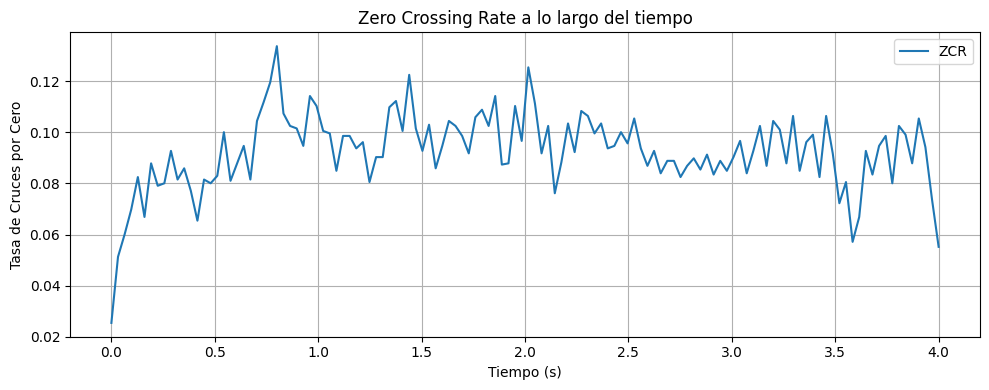

In [21]:
# Cargamos audio
y, sr = librosa.load("audio_construccion.wav", sr=16000, mono=True)

# Zero Crossing Rate
plot_zero_crossing(y, sr)

In [ ]:
import numpy as np

# zcr es el array de tasas por frame que calculamos antes
var_zcr = np.var(zcr)
# rms por frame
import librosa
rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
var_rms = np.var(rms)

# Si ambas varianzas son muy bajas => se√±al homog√©nea (m√∫sica/ambiente)


#### **Spectral centroid y Spectral Rollrof**

In [43]:
import numpy as np
# Parche para compatibilidad librosa/numpy
np.complex = complex

import librosa
import librosa.display
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing

def plot_spectral_centroid_same_scale(y: np.ndarray, sr: int):
    """
    Plotea el waveform normalizado y el Spectral Centroid normalizado,
    ambos en la misma escala [0, 1].

    - Waveform: normalizado min-max.
    - Spectral Centroid: normalizado min-max.
    """
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    # Computing the time variable for visualization
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)

    # Normalising function for visualisation
    def normalize(y, axis=0):
        return preprocessing.minmax_scale(y, axis=axis)

    #Plotting the Spectral Centroid along the waveform
    librosa.display.waveshow(y, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.grid()
    plt.show()


def plot_spectral_rolloff_same_scale(y: np.ndarray, sr: int, roll_percent: float = 0.85):
    """
    Plotea el waveform normalizado y el Spectral Rolloff normalizado,
    ambos en la misma escala [0, 1].

    - Waveform: normalizado min-max.
    - Spectral Rolloff: normalizado min-max.
    """
    # Normalising the spectral centroid for visualisation
    def normalize(x, axis=0):
        return sklearn.preprocessing.minmax_scale(x, axis=axis)
    
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y + 0.01, sr=sr)[0] # - y=y+0.01: Se a√±ade 0.01 a la se√±al para evitar problemas num√©ricos (por ejemplo, evitar dividir entre cero).
    t = librosa.frames_to_time(range(len(spectral_rolloff)), sr=sr)
    librosa.display.waveshow(y, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.grid()


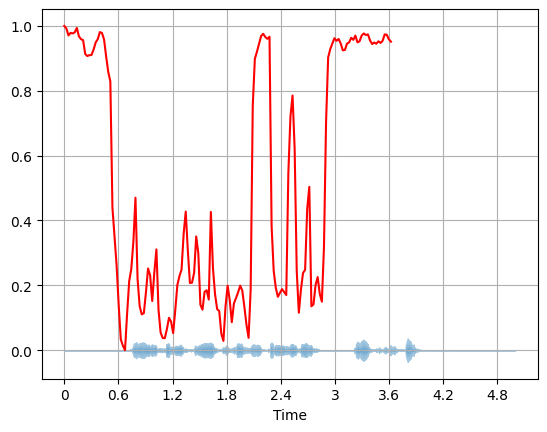

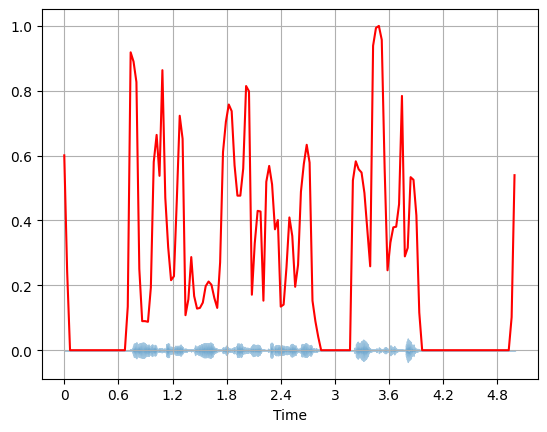

In [44]:
# Ejemplo de uso:
# Cargamos audio
y, sr = librosa.load("data\outputs\\6_audios\\administracion\\audio_3.wav", sr=16000, mono=True)
plot_spectral_centroid_same_scale(y, sr)
plot_spectral_rolloff_same_scale(y, sr)


In [1]:
import librosa
import numpy as np

def extract_features(path, sr=16000, n_mfcc=13):
    # 1) cargar audio
    y, _ = librosa.load(path, sr=sr, mono=True)
    # 2) recortar silencios al inicio/final
    y, _ = librosa.effects.trim(y)
    # 3) pre-√©nfasis
    y = np.append(y[0], y[1:] - 0.97 * y[:-1])
    # 4) extraer MFCCs ‚Äî aqu√≠ s√≥lo con keyword args
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # 5) devolver resumen: media y varianza de cada coeficiente
    return np.hstack([mfccs.mean(axis=1), mfccs.var(axis=1)])


In [9]:
features = []
for _, row in df.iterrows():
    vec = extract_features(row["path"])
    features.append(vec)
X = np.vstack(features)
y = df["label"].values


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)


In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

                     precision    recall  f1-score   support

     administracion       1.00      1.00      1.00         1
efectos_secundarios       0.67      1.00      0.80         2
              otros       1.00      0.50      0.67         2

           accuracy                           0.80         5
          macro avg       0.89      0.83      0.82         5
       weighted avg       0.87      0.80      0.79         5

[[1 0 0]
 [0 2 0]
 [0 1 1]]
